In [1]:
# Include torchtrainer in the import path
import sys
sys.path.insert(0, '../../')

In [55]:
# Initial imports and device setting
from pathlib import Path
from functools import partial
import matplotlib.pyplot as plt
import torch
from torch.functional import F
import torchvision
import torchvision.transforms as tv_transforms
import torchtrainer
from torchtrainer.learner import Learner
from torchtrainer.models import resunet
from torchtrainer import img_util
from torchtrainer import transforms
from torchtrainer.imagedataset import ImageSegmentationDataset
import imgaug.augmenters as iaa

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [56]:
# Create dataloaders
def get_data():
    """Download example dataset containing rivers for segmentation (it is one of the classes 
    from the COCO dataset). The dataset has 150MB and will be saved on data/river.
    There is not progress bar for the download, so hold tight!
    """

    import urllib.request
    from zipfile import ZipFile
    import io
    
    file_url = 'https://www.dropbox.com/s/we8q6gh3nzaraw8/river.zip?dl=1'
    
    if not Path('data/river').is_dir():
        response = urllib.request.urlopen(file_url)
        file_stream = response.read()
        file = io.BytesIO(file_stream)
        ZipFile(file, 'r').extractall('data')
        
def name_to_label_map(img_filename):
    """Function that receives an image filename and return the filename 
    of the respective lable image."""
    
    return img_filename.replace('jpg', 'png')
    
root_dir = Path('data/river/train')
img_dir = root_dir/'images'
label_dir = root_dir/'labels'
    
get_data()

# Note that default torchvision transforms won't work because we need to also
# transform labels in some cases
imgaug_seq = iaa.Sequential([
                            iaa.Resize({"height": 320, "width": 320}),
                            ])
tn = transforms.TransfNormalize(True, False)
transform_funcs = transforms.seq_pil_to_imgaug_to_tensor(imgaug_seq)
transform_funcs += [transforms.TransfNormalize(), 
                    transforms.TransfWhitten((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]

# Create functions for reading images
img_opener = img_util.pil_img_opener
label_opener = partial(img_util.pil_img_opener, is_label=True)

# Create ImageSegmentationDataset instance
dataset = ImageSegmentationDataset(img_dir, label_dir, name_to_label_map=name_to_label_map, 
                                   img_opener=img_opener, label_opener=label_opener)
trainset, validset = dataset.split_train_val(0.1)
trainset.set_transforms(transform_funcs)
validset.set_transforms(transform_funcs)

trainloader = trainset.dataloader(batch_size=5, shuffle=True)
validloader = validset.dataloader(batch_size=5, shuffle=False)

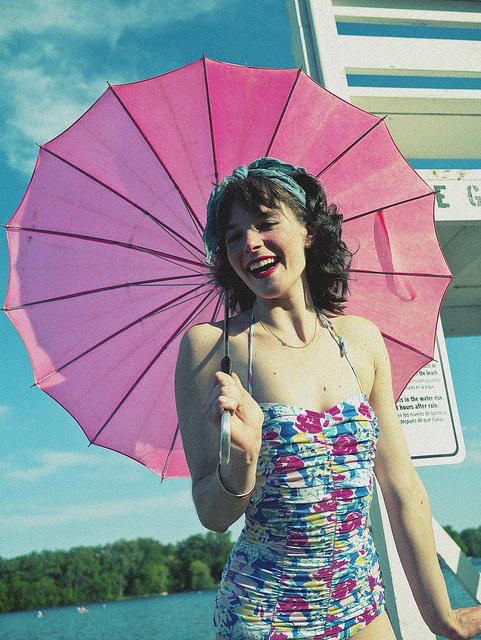

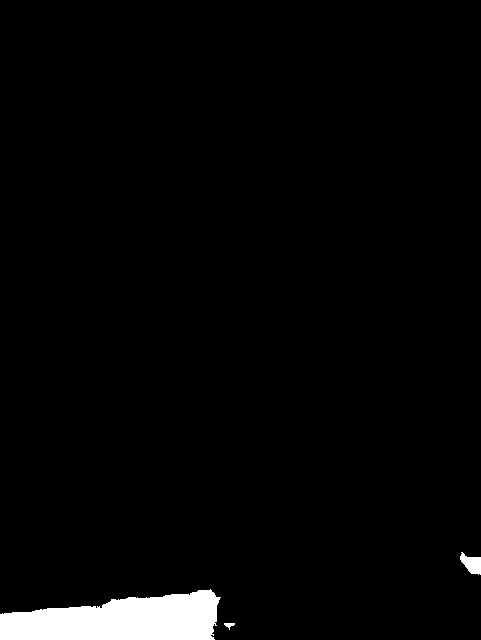

In [57]:
# Visualize images in the dataset
# We can use the get_item method to obtain the original images (if we use trainset[0], the images will be already
# transformed and might not be adequate for visualizing)
img, label = trainset.get_item(0)
img_util.show(img)
img_util.show(label, binary=True)

In [ ]:
%%time

loss_func = F.cross_entropy
model = resunet.ResUNet(num_channels=3, num_classes=2)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

learner = Learner(model, loss_func, optimizer, trainloader, validloader, scheduler, 
                       acc_funcs=None)

learner.fit(2)

Epoch       Train loss     Valid loss


In [ ]:
# Plot loss and accuracy history
plt.figure()
plt.plot(learner.train_loss_history)
plt.plot(learner.valid_loss_history)
plt.figure()
plt.plot(learner.lr_history)
plt.figure()
plt.plot(learner.acc_funcs_history['acc'])

In [ ]:
# After training, we can load the model for inference. Be sure to first recreate `model` 
# exactly as it was defined during training
checkpoint = torch.load('learner.tar')
model.load_state_dict(checkpoint['model_state'])
  
model.to(device)
model.eval()

img, label = testset[0]
img = img.unsqueeze(0).to('cuda')
with torch.no_grad():
    prediction = model(img)
    
print(f'Label: {label}, Predicted: {prediction.argmax()}')